In [1]:
# Import libraries
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import implicit
#import pandas_profiling
import os, sys
import datetime
from __future__ import division, print_function, unicode_literals

# Data Prep

In [2]:
#import dataset products.csv (here we use the full dataset)
products = pd.read_csv('products.csv')
products.shape  #155919 rows, 10 columns
products.head() 
products.dtypes #check data type for each column
products.isna().sum() #check NA values for each column
products = products.dropna() #drop NA values
products.shape #3000+ rows dropped

(152578, 10)

In [3]:
# Looking to see what product ids ACSE have which is competing in the carbonated soft drink market with coke and pepsi
products[products['prod_subcategory'].str.contains('Carbonated Soft Drin', na = False) \
         & products['prod_mfc_brand_cd'].str.contains('ACSE', na = False)]

# Make a list of the product ids that ACSE make in the carbonated soft drink subcategory
acsedrinks = products[products['prod_subcategory'].str.contains('Carbonated Soft Drin', na = False) \
                      & products['prod_mfc_brand_cd'].str.contains('ACSE', na = False)]['prod_id'].unique()

print('Number of ACSE branded CSD ={:d}'.format(len(acsedrinks)))

Number of ACSE branded CSD =85


In [4]:
#import transactions dataset (randomly sampled using the builtin randomizer of pandas)
transactions = pd.read_csv('transactions_sampled_v5.csv')
transactions = transactions.iloc[: , 1:]
transactions.head()
#Negative sales amount and quantity don't make sense, filter out those rows
transactions.drop(transactions[transactions['sales_amt'] < 0].index, inplace = True)
transactions.drop(transactions[transactions['sales_qty'] < 0].index, inplace = True)


print("The shape of this subset of transactions dataset is ",(transactions.shape))

The shape of this subset of transactions dataset is  (11907126, 8)


In [5]:
# transactions = 

# transactions.head()

# transactions.dtypes # trans_dt is an object and not datetime

transactions['month'] = pd.to_datetime(transactions['trans_dt']).dt.month
transactions.head(6)

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month
0,170625010050404567,6/25/2017,1005,1008061498,21031312,2.49,1,0.0,6
1,170624010220809847,6/24/2017,1022,1133995672,20189092,0.05,1,0.0,6
2,170624010100701456,6/24/2017,1010,60003034881280,20708931,11.99,1,0.0,6
3,170624010210702469,6/24/2017,1021,1008762288,20169567,9.00,1,0.2,6
4,170624010660808197,6/24/2017,1066,1148460508,20314333,34.38,3,0.0,6
5,170624010320404828,6/24/2017,1032,1123949686,20299983020,3.99,1,0.0,6


In [6]:
#calculate unit price
transactions['unit_price'] = transactions.sales_amt/transactions.sales_qty

transactions.head(5)

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price
0,170625010050404567,6/25/2017,1005,1008061498,21031312,2.49,1,0.0,6,2.49
1,170624010220809847,6/24/2017,1022,1133995672,20189092,0.05,1,0.0,6,0.05
2,170624010100701456,6/24/2017,1010,60003034881280,20708931,11.99,1,0.0,6,11.99
3,170624010210702469,6/24/2017,1021,1008762288,20169567,9.00,1,0.2,6,9.00
4,170624010660808197,6/24/2017,1066,1148460508,20314333,34.38,3,0.0,6,11.46


In [7]:
# Merging the products and transactions table to find how many customers buy acse branded csds
merged = transactions.merge(products, how="inner", on="prod_id")

merged.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170625010050404567,6/25/2017,1005,1008061498,21031312,2.49,1,0.0,6,2.49,QP TORTILLA CHIPS RED CORN,Natural Foods,Natural Foods,Snacks-Natural Foods,Chips,QUPA,1.0,G,300.0
1,170624010190805778,6/24/2017,1019,1100611737,21031312,2.49,1,0.0,6,2.49,QP TORTILLA CHIPS RED CORN,Natural Foods,Natural Foods,Snacks-Natural Foods,Chips,QUPA,1.0,G,300.0
2,170624010010806725,6/24/2017,1001,1016601259,21031312,2.49,1,0.0,6,2.49,QP TORTILLA CHIPS RED CORN,Natural Foods,Natural Foods,Snacks-Natural Foods,Chips,QUPA,1.0,G,300.0
3,170624010270807847,6/24/2017,1027,1021650510,21031312,2.49,1,0.0,6,2.49,QP TORTILLA CHIPS RED CORN,Natural Foods,Natural Foods,Snacks-Natural Foods,Chips,QUPA,1.0,G,300.0
4,170625010040707767,6/25/2017,1004,1128987709,21031312,2.49,1,0.0,6,2.49,QP TORTILLA CHIPS RED CORN,Natural Foods,Natural Foods,Snacks-Natural Foods,Chips,QUPA,1.0,G,300.0


In [8]:
merged[merged['prod_id'].isin (acsedrinks)] # there are 21899 rows/ transactions with acse drinks

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
464296,170624011740508430,6/24/2017,1174,60002556860230,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
464297,170624010220809962,6/24/2017,1022,1128469653,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
464298,170624011550602968,6/24/2017,1155,60003025105400,20311645005,2.97,3,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
464299,170625010190605868,6/25/2017,1019,1131076535,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
464300,170628011140705635,6/28/2017,1114,1130289639,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11706229,201218010662209503,12/18/2020,1066,1128646787,21297356,8.00,2,0.0,12,4.00,ACSE DT TONIC,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,ACSE,12.0,ML,355.0
11706230,201221011880509730,12/21/2020,1188,1124000404,21297356,8.00,2,0.0,12,4.00,ACSE DT TONIC,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,ACSE,12.0,ML,355.0
11706231,201223010140500419,12/23/2020,1014,1125743135,21297356,4.00,1,0.0,12,4.00,ACSE DT TONIC,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,ACSE,12.0,ML,355.0
11706232,201220011270207405,12/20/2020,1127,1137599570,21297356,4.00,1,0.0,12,4.00,ACSE DT TONIC,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,ACSE,12.0,ML,355.0


In [9]:
len(merged[merged['prod_id'].isin (acsedrinks)]['cust_id'].unique()) 
# There are 19241 customers who bought acse branded csds over the years in this sampled dataset

19241

In [10]:
merged.groupby('month').sales_amt.sum()

month
1     4527271.68
2     4209361.78
3     5251409.95
4     4845051.42
5     5099997.18
6     5232262.49
7     5868547.81
8     5733791.56
9     5113697.32
10    6247226.02
11    5524908.20
12    6160303.93
Name: sales_amt, dtype: float64

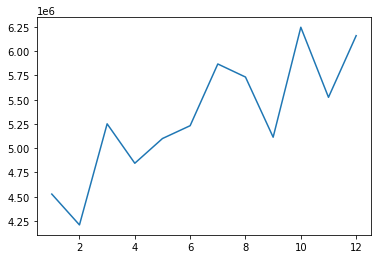

In [11]:
plt.plot(merged.groupby('month').sales_amt.sum()) # there is seasonality in the total acse sales data

# Pepsi Seasonality Analysis

In [12]:
#here we take the subset of products data where filtering on only pepsi products
pepsi = products[products['prod_desc'].str.contains(r'PEPSI|Pepsi|pepsi', na = False)\
                & products['prod_subcategory'].str.contains('Carbonated Soft Drin', na = False)]
pepsi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 25262 to 149981
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prod_id              56 non-null     float64
 1   prod_desc            56 non-null     object 
 2   prod_section         56 non-null     object 
 3   prod_category        56 non-null     object 
 4   prod_subcategory     56 non-null     object 
 5   prod_type            56 non-null     object 
 6   prod_mfc_brand_cd    56 non-null     object 
 7   prod_unit_qty_count  56 non-null     float64
 8   prod_count_uom       56 non-null     object 
 9   prod_uom_value       56 non-null     float64
dtypes: float64(3), object(7)
memory usage: 4.8+ KB


In [13]:
#types of pepsi products
np.unique(pepsi.prod_desc)

array(['CRYSTAL PEPSI', 'DIET PEPSI', 'DIET PEPSI GLASS',
       'DIET PEPSI SLEEK', 'DIET PEPSI SUGAR FREE', 'PEPSI', 'PEPSI 1LT',
       'PEPSI CAFFEINE FREE', 'PEPSI COLA', 'PEPSI COLA DIET',
       'PEPSI COLA DIET CAFFEINE FREE', 'PEPSI DIET',
       'PEPSI DIET CAFFEINE FREE', 'PEPSI DIET LIME', 'PEPSI DIET MAX',
       'PEPSI DIET WILD CHERRY', 'PEPSI FLAVOURS BERRY',
       'PEPSI FLAVOURS MANGO', 'PEPSI GLASS BOTTLE', 'PEPSI LEMON TWIST',
       'PEPSI LIME', 'PEPSI MAX', 'PEPSI MINI CANS, 7UP',
       'PEPSI MINI CANS, CRUSH ORANGE', 'PEPSI MINI CANS, DIET PEPSI',
       'PEPSI MINI CANS, GINGER ALE', 'PEPSI MINI CANS, PEPSI',
       'PEPSI NEXT', 'PEPSI NEXT 12X355ML', 'PEPSI REAL LIME',
       'PEPSI SLEEK', 'PEPSI THROWBACK', 'PEPSI VANILLA',
       'PEPSI WILD CHERRY', 'PEPSI ZERO SUGAR', 'PEPSI ZERO SUGAR MINIS'],
      dtype=object)

In [14]:
##to make sure the brand is pepsi only, excluding some potentially joint signed products
pepsi = pepsi.loc[pepsi.prod_mfc_brand_cd == 'PEPS']

In [15]:
np.unique(pepsi.prod_desc) 
# there are repititions of the same brand name like COCA COLA & COCA-COLA & between all capital and camel letters

array(['CRYSTAL PEPSI', 'DIET PEPSI', 'DIET PEPSI GLASS',
       'DIET PEPSI SLEEK', 'DIET PEPSI SUGAR FREE', 'PEPSI', 'PEPSI 1LT',
       'PEPSI CAFFEINE FREE', 'PEPSI COLA', 'PEPSI COLA DIET',
       'PEPSI COLA DIET CAFFEINE FREE', 'PEPSI DIET',
       'PEPSI DIET CAFFEINE FREE', 'PEPSI DIET LIME', 'PEPSI DIET MAX',
       'PEPSI DIET WILD CHERRY', 'PEPSI FLAVOURS BERRY',
       'PEPSI FLAVOURS MANGO', 'PEPSI GLASS BOTTLE', 'PEPSI LEMON TWIST',
       'PEPSI LIME', 'PEPSI MAX', 'PEPSI MINI CANS, 7UP',
       'PEPSI MINI CANS, DIET PEPSI', 'PEPSI MINI CANS, PEPSI',
       'PEPSI NEXT', 'PEPSI NEXT 12X355ML', 'PEPSI REAL LIME',
       'PEPSI SLEEK', 'PEPSI THROWBACK', 'PEPSI VANILLA',
       'PEPSI WILD CHERRY', 'PEPSI ZERO SUGAR', 'PEPSI ZERO SUGAR MINIS'],
      dtype=object)

In [16]:
pepsi["prod_desc"].replace({"PEPSI COLA DIET": "PEPSI DIET", \
                           "PEPSI COLA": "PEPSI"}, inplace=True)

In [17]:
#delete those products which are not available in 2022
discontinued = ['CRYSTAL PEPSI', 'DIET PEPSI GLASS','PEPSI LEMON TWIST','PEPSI DIET LIME', 'PEPSI NEXT','PEPSI NEXT 12X355ML','PEPSI REAL LIME','PEPSI THROWBACK','PEPSI VANILLA','PEPSI FLAVOURS BERRY', 'PEPSI FLAVOURS MANGO','PEPSI DIET MAX','PEPSI MAX','PEPSI MINI CANS, 7UP'  ]
pepsi = pepsi.loc[~pepsi.prod_desc.isin(discontinued)]

In [18]:
#now we want to merge pepsi dataset with transactions dataset based on "product id"
pepsi_tra = transactions.merge(pepsi, how="inner", on="prod_id")

In [19]:
pepsi_tra.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170624010640408510,6/24/2017,1064,1044026259,20322361006,9.99,3,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
1,170624010290808357,6/24/2017,1029,1008959667,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
2,170624010160103157,6/24/2017,1016,1012313843,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
3,170625010040209302,6/25/2017,1004,1124187080,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
4,170625010220403107,6/25/2017,1022,1134156445,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0


In [20]:
#trans_dt column has month/date/year in the same column, 
#we want to add 3 extra columns only containing date, month and year info, respectivelly
pepsi_tra = pd.concat([pepsi_tra, 
          (pepsi_tra.trans_dt.str.split("/").str[:3].apply(pd.Series)
          .rename(columns={ 1:'date', 2:'year'}))], axis = 1)

In [21]:
pepsi_tra.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,0,date,year
0,170624010640408510,6/24/2017,1064,1044026259,20322361006,9.99,3,0.0,6,3.33,...,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0,6,24,2017
1,170624010290808357,6/24/2017,1029,1008959667,20322361006,3.33,1,0.0,6,3.33,...,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0,6,24,2017
2,170624010160103157,6/24/2017,1016,1012313843,20322361006,3.33,1,0.0,6,3.33,...,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0,6,24,2017
3,170625010040209302,6/25/2017,1004,1124187080,20322361006,3.33,1,0.0,6,3.33,...,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0,6,25,2017
4,170625010220403107,6/25/2017,1022,1134156445,20322361006,3.33,1,0.0,6,3.33,...,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0,6,25,2017


In [22]:
#make sure we have 4 years (2017-2020)
np.unique(pepsi_tra['year'])

array(['2017', '2018', '2019', '2020'], dtype=object)

In [23]:
#check months
pepsi_tra['month'] = pepsi_tra['month'].astype(int)
np.unique(pepsi_tra['month'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

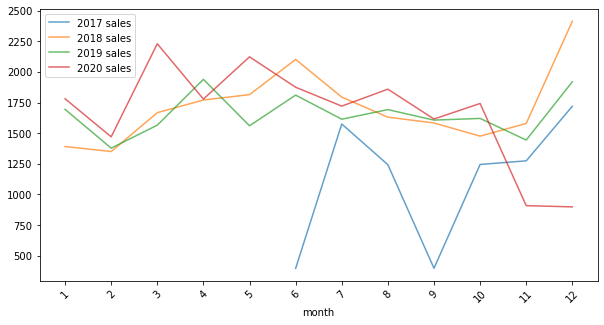

In [24]:
#look into seasonality for each year
#the data is starting from July,2017, therefore missing Jan~May dataset in year 2017
from matplotlib.pyplot import figure
figure(figsize=(10,5))
a0=pepsi_tra.loc[pepsi_tra.year=='2017'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2017 sales")
a1=pepsi_tra.loc[pepsi_tra.year=='2018'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2018 sales")
a2=pepsi_tra.loc[pepsi_tra.year=='2019'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2019 sales")
a2=pepsi_tra.loc[pepsi_tra.year=='2020'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2020 sales")

b1=plt.xticks(np.arange(1,13,1),rotation=45)
b2=a0.legend(loc='upper left')

# Coca Cola Seasonality Analysis

In [25]:
#in products data, filter out coca cola products only
coca = products[products['prod_desc'].str.contains(r'COCA|Coca|coca|coke', na = False) \
        & products['prod_subcategory'].str.contains('Carbonated Soft Drin', na = False)]
coca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 12687 to 141689
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prod_id              54 non-null     float64
 1   prod_desc            54 non-null     object 
 2   prod_section         54 non-null     object 
 3   prod_category        54 non-null     object 
 4   prod_subcategory     54 non-null     object 
 5   prod_type            54 non-null     object 
 6   prod_mfc_brand_cd    54 non-null     object 
 7   prod_unit_qty_count  54 non-null     float64
 8   prod_count_uom       54 non-null     object 
 9   prod_uom_value       54 non-null     float64
dtypes: float64(3), object(7)
memory usage: 4.6+ KB


In [26]:
coca.head(10) #brief look into the dataset

,prod_id,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
12687,20299050.0,COCA COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.00
23146,20659785.0,COCA COLA ZERO 1L,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.00
31579,20783410.0,COCA COLA DIET,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.00
35344,20827293.0,COCA-COLA CLASSIC 500ML BOTTLE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.00
41698,20894725.0,COCA COLA CLASSIC SLIM CAN,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,310.00
41764,20895307.0,COCA COLA CHERRY,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.00
46391,20941145.0,COCA-COLA CHERRY,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,24.0,ML,355.00
51482,20968251.0,COCA-COLA VANILLA,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.00
52057,20970984.0,COCA-COLA CLASSIC,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.25
56875,20990930.0,COCA-COLA LIFE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,6.0,ML,222.00


In [27]:
##to make sure the brand is coca cola only, excluding some potentially joint signed products
coca = coca.loc[coca.prod_mfc_brand_cd == 'COCA']

In [28]:
np.unique(coca.prod_desc) 
# there are repititions of the same brand name like COCA COLA & COCA-COLA & between all capital and camel letters

array(['COCA COLA', 'COCA COLA CHERRY', 'COCA COLA CHERRY VANILLA ZS',
       'COCA COLA CLASSIC SLIM CAN', 'COCA COLA DE MEXICO',
       'COCA COLA DIET', 'COCA COLA DIET FEISTY CHERRY',
       'COCA COLA GEORGIA PEACH', 'COCA COLA ZERO', 'COCA COLA ZERO 1L',
       'COCA COLA ZERO CHERRY', 'COCA- COLA ZERO', 'COCA-COLA',
       'COCA-COLA BC RASPBERRY', 'COCA-COLA CHERRY',
       'COCA-COLA CHERRY VAN ZERO SUG', 'COCA-COLA CHERRY VANILLA',
       'COCA-COLA CLASSIC', 'COCA-COLA CLASSIC 500ML BOTTLE',
       'COCA-COLA DIET', 'COCA-COLA DIET BLOOD ORANGE',
       'COCA-COLA DIET CHERRY', 'COCA-COLA DIET GINGER LIME',
       'COCA-COLA DIET MANGO', 'COCA-COLA FRIDGEMATE', 'COCA-COLA LIFE',
       'COCA-COLA LIME', 'COCA-COLA ORANGE VANILLA',
       'COCA-COLA QUEBEC MAPLE', 'COCA-COLA RASPBERRY',
       'COCA-COLA STEVIA', 'COCA-COLA VANILLA', 'COCA-COLA ZERO',
       'COCA-COLA ZERO CHERRY', 'COCA-COLA ZERO SUGAR', 'Coca-Cola Diet',
       'Coca-Cola Zero'], dtype=object)

In [29]:
coca["prod_desc"].replace({"COCA- COLA ZERO": "COCA-COLA ZERO", \
                           "COCA COLA": "COCA-COLA", \
                          "COCA COLA ZERO":"COCA-COLA ZERO", \
                          "Coca-Cola Diet": "COCA-COLA DIET", \
                           "COCA COLA DIET": "COCA-COLA DIET", \
                          "Coca-Cola Zero": "COCA-COLA ZERO", \
                          "COCA COLA ZERO CHERRY":"COCA-COLA ZERO CHERRY", \
                          "COCA COLA ZERO 1L": "COCA-COLA ZERO 1L", \
                          "COCA COLA CLASSIC SLIM CAN": "COCA-COLA CLASSIC SLIM CAN"}, inplace=True)

In [30]:
np.unique(coca.prod_desc) 

array(['COCA COLA CHERRY', 'COCA COLA CHERRY VANILLA ZS',
       'COCA COLA DE MEXICO', 'COCA COLA DIET FEISTY CHERRY',
       'COCA COLA GEORGIA PEACH', 'COCA-COLA', 'COCA-COLA BC RASPBERRY',
       'COCA-COLA CHERRY', 'COCA-COLA CHERRY VAN ZERO SUG',
       'COCA-COLA CHERRY VANILLA', 'COCA-COLA CLASSIC',
       'COCA-COLA CLASSIC 500ML BOTTLE', 'COCA-COLA CLASSIC SLIM CAN',
       'COCA-COLA DIET', 'COCA-COLA DIET BLOOD ORANGE',
       'COCA-COLA DIET CHERRY', 'COCA-COLA DIET GINGER LIME',
       'COCA-COLA DIET MANGO', 'COCA-COLA FRIDGEMATE', 'COCA-COLA LIFE',
       'COCA-COLA LIME', 'COCA-COLA ORANGE VANILLA',
       'COCA-COLA QUEBEC MAPLE', 'COCA-COLA RASPBERRY',
       'COCA-COLA STEVIA', 'COCA-COLA VANILLA', 'COCA-COLA ZERO',
       'COCA-COLA ZERO 1L', 'COCA-COLA ZERO CHERRY',
       'COCA-COLA ZERO SUGAR'], dtype=object)

In [31]:
#delete thoses products which are not avavilable in 2022
discontinued1 = ['COCA COLA DE MEXICO','COCA-COLA STEVIA','COCA-COLA LIFE']
coca = coca.loc[~coca.prod_desc.isin(discontinued1)]
coca.head()

,prod_id,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
12687,20299050.0,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.0
23146,20659785.0,COCA-COLA ZERO 1L,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.0
31579,20783410.0,COCA-COLA DIET,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,1.0
35344,20827293.0,COCA-COLA CLASSIC 500ML BOTTLE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.0
41698,20894725.0,COCA-COLA CLASSIC SLIM CAN,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,310.0


In [32]:
#join coca cola data with transactions
coca_tra = transactions.merge(coca, how="inner", on="prod_id")

In [33]:
coca_tra.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0


In [34]:
#again,trans_dt column has month/date/year in the same column, 
#we want to add 3 extra columns only containing date, month and year info, respectivelly
coca_tra = pd.concat([coca_tra, 
          (coca_tra.trans_dt.str.split("/").str[:3].apply(pd.Series)
          .rename(columns={1:'date', 2:'year'}))], axis = 1)
coca_tra

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,0,date,year
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34727,200817010900308427,8/17/2020,1090,1128776079,21295933,8.00,4,0.0,8,2.00,...,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.0,8,17,2020
34728,200821010070600904,8/21/2020,1007,1123909498,21295933,2.29,1,0.0,8,2.29,...,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.0,8,21,2020
34729,200829010215008493,8/29/2020,1021,1116966188,21295933,2.00,1,0.0,8,2.00,...,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.0,8,29,2020
34730,200830011420203449,8/30/2020,1142,1133982740,21295933,2.29,1,0.0,8,2.29,...,Cold Beverages,Carbonated Soft Drin,Cans,COCA,1.0,ML,500.0,8,30,2020


In [35]:
#make sure we have 4 years (2017-2020)
np.unique(coca_tra['year'])

array(['2017', '2018', '2019', '2020'], dtype=object)

In [36]:
#check months
coca_tra['month'] = coca_tra['month'].astype(int)
np.unique(coca_tra['month'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

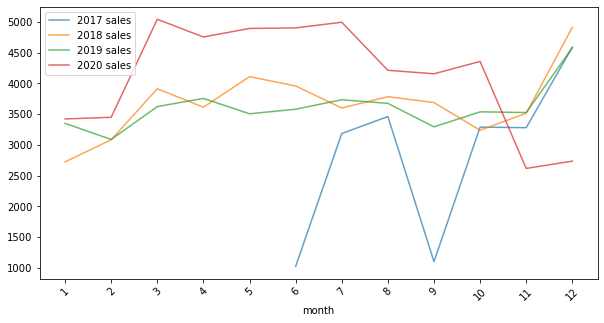

In [37]:
#look into seasonality for each year
#the data is starting from July,2017, therefore missing Jan~May dataset in year 2017
from matplotlib.pyplot import figure
figure(figsize=(10,5))
a0=coca_tra.loc[coca_tra.year=='2017'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2017 sales")
a1=coca_tra.loc[coca_tra.year=='2018'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2018 sales")
a2=coca_tra.loc[coca_tra.year=='2019'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2019 sales")
a2=coca_tra.loc[coca_tra.year=='2020'].groupby('month').sales_amt.sum().plot(alpha=0.7,label="2020 sales")

b1=plt.xticks(np.arange(1,13,1),rotation=45)
b2=a0.legend(loc='upper left')

In [38]:
coca_tra.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,0,date,year
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017


# Finding customers who bought acse csd products

In [39]:
acsecust = transactions[transactions['prod_id'].isin (acsedrinks)]['cust_id'].unique()
len(acsecust) 
# there are 19,241 customers who bought acse drinks.

19241

In [40]:
# subsetting the dataset for customers who bought acse csd
acse = transactions[transactions['prod_id'].isin (acsedrinks)]
acse.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price
14,170624011740508430,6/24/2017,1174,60002556860230,20311645005,0.99,1,0.0,6,0.99
427,170624010640507587,6/24/2017,1064,1129900372,20690671001,3.00,1,0.0,6,3.00
933,170624010212602837,6/24/2017,1021,1008685226,20152117031,3.00,1,0.0,6,3.00
1523,170624011790603446,6/24/2017,1179,1150165654,20311645006,0.99,1,0.0,6,0.99
1530,170626011700909441,6/26/2017,1170,60002630130610,20311645007,0.99,1,0.0,6,0.99


In [41]:
acse = acse.merge(products, how = "inner", on = "prod_id")
acse.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170624011740508430,6/24/2017,1174,60002556860230,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
1,170624010220809962,6/24/2017,1022,1128469653,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
2,170624011550602968,6/24/2017,1155,60003025105400,20311645005,2.97,3,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
3,170625010190605868,6/25/2017,1019,1131076535,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0
4,170628011140705635,6/28/2017,1114,1130289639,20311645005,0.99,1,0.0,6,0.99,ACSE CLUB SODA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,ACSE,1.0,L,2.0


In [42]:
print ("The Total sales for ACSE csd are: {:.3f}".format (acse.sales_amt.sum()) )

The Total sales for ACSE csd are: 69495.850


In [43]:
acse.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False) / acse.sales_amt.sum()

prod_desc
ACSE CLUB SODA LOW SODIUM            0.285724
ACSE GINGER ALE                      0.055178
ACSE DIET GINGERALE FRIDGE           0.047355
ACSE CAFFEINE FREE DIET COLA FM      0.038445
ACSE DIET SPARKLING LEMONADE FM      0.035680
ACSE TONIC FM                        0.033099
ACSE CLUB SODA                       0.028395
ACSE TONIC WATER DIET                0.024938
ACSE DIET COLA FM                    0.024770
ACSE TONIC WATER                     0.024318
ACSE GINGER ALE DIET                 0.023033
ACSE COLA DIET CAFFEINE FREE         0.022218
ACSE COLA FM                         0.020959
ACSE DIET SPRITZ UP FM               0.020670
ACSE COLA DIET                       0.019286
ACSE CRANBERRY GINGERALE FP          0.018003
ACSE COLA                            0.017061
ACSE SPKLNG 12PK 355ML WTRMN LEM     0.014866
ACSE SPARKLING LEMONADE FM           0.014650
ACSE DIET GRAPEFRUIT FM              0.014504
ACSE SPRITZ UP LIGHT                 0.013993
ACSE DIET TONIC WATER   

In [44]:
# getting rid of the acse customers from the april transaction data

transactions = transactions[~transactions['cust_id'].isin (acsecust)]
transactions.shape

(11581878, 10)

# Market share by Product Category

Coca-cola market share

In [45]:
# merge coca dataset with transactions dataset that does not have any acse customers
# so that we have info of coca products without acse customers
coca4= transactions.merge(coca, how="inner", on="prod_id")

In [46]:
coca4.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,COCA-COLA,Grocery,Cold Beverages,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0


In [47]:
print ("The Total sales for Coca-cola csd are: {:.3f}".format (coca4.sales_amt.sum()) )

The Total sales for Coca-cola csd are: 152071.100


In [48]:
#calculate the sales of each coca product divided by total mkt share
market_share_coca = \
round(coca4.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False) / coca4.sales_amt.sum(),2)

market_share_coca


prod_desc
COCA-COLA ZERO                    0.26
COCA-COLA FRIDGEMATE              0.23
COCA-COLA DIET                    0.20
COCA-COLA                         0.13
COCA-COLA CLASSIC                 0.09
COCA-COLA CLASSIC 500ML BOTTLE    0.05
COCA-COLA BC RASPBERRY            0.01
COCA-COLA QUEBEC MAPLE            0.00
COCA-COLA ZERO SUGAR              0.00
COCA-COLA ZERO CHERRY             0.00
COCA-COLA ORANGE VANILLA          0.00
COCA-COLA CHERRY VANILLA          0.00
COCA-COLA VANILLA                 0.00
COCA COLA GEORGIA PEACH           0.00
COCA COLA DIET FEISTY CHERRY      0.00
COCA-COLA CHERRY VAN ZERO SUG     0.00
COCA-COLA CHERRY                  0.00
COCA COLA CHERRY                  0.00
COCA-COLA LIME                    0.00
COCA-COLA RASPBERRY               0.00
COCA-COLA DIET CHERRY             0.00
COCA COLA CHERRY VANILLA ZS       0.00
COCA-COLA DIET BLOOD ORANGE       0.00
COCA-COLA DIET MANGO              0.00
COCA-COLA DIET GINGER LIME        0.00
COCA-COLA ZERO 

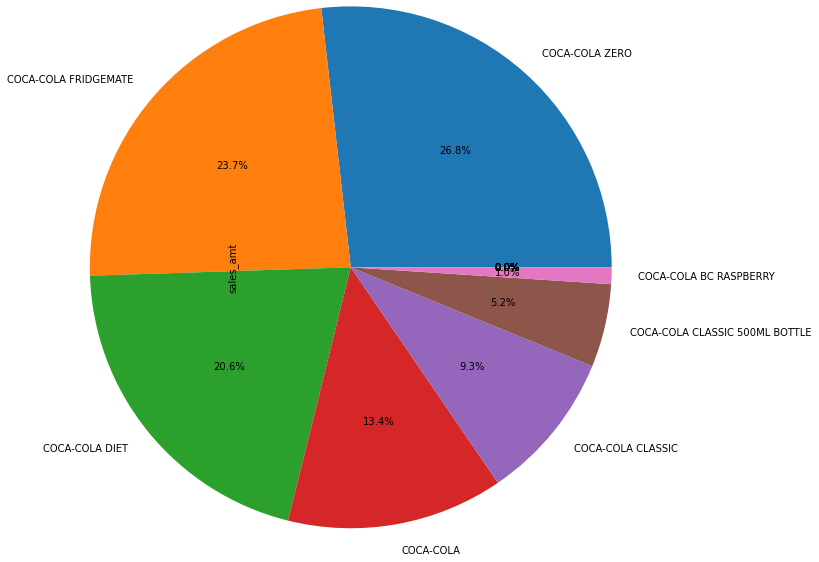

In [49]:
# Market share pie plot
market_share_coca.plot.pie(autopct="%.1f%%", radius = 3,normalize=True);

Pepsi market share

In [50]:
# merge pepsi dataset with transactions dataset that does not have any acse customers
# so that we have info of pepsi products without acse customers
pepsi4= transactions.merge(pepsi, how="inner", on="prod_id")

In [51]:
pepsi4.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
0,170624010640408510,6/24/2017,1064,1044026259,20322361006,9.99,3,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
1,170624010290808357,6/24/2017,1029,1008959667,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
2,170624010160103157,6/24/2017,1016,1012313843,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
3,170625010040209302,6/25/2017,1004,1124187080,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0
4,170625010220403107,6/25/2017,1022,1134156445,20322361006,3.33,1,0.0,6,3.33,PEPSI COLA DIET CAFFEINE FREE,Grocery,Cold Beverages,Carbonated Soft Drin,Cans,PEPS,12.0,ML,355.0


In [52]:
print ("The Total sales for Pepsi csd are: {:.3f}".format (pepsi4.sales_amt.sum()) )

The Total sales for Pepsi csd are: 65953.310


In [53]:
#calculate the sales of each pepsi product divided by total mkt share
market_share_pepsi = round(pepsi4.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False) / pepsi4.sales_amt.sum(),2)

market_share_pepsi

prod_desc
PEPSI                            0.36
PEPSI DIET                       0.35
PEPSI COLA DIET CAFFEINE FREE    0.07
PEPSI MINI CANS, PEPSI           0.05
PEPSI MINI CANS, DIET PEPSI      0.04
PEPSI SLEEK                      0.02
PEPSI WILD CHERRY                0.02
DIET PEPSI SLEEK                 0.02
PEPSI DIET WILD CHERRY           0.02
PEPSI DIET CAFFEINE FREE         0.02
PEPSI CAFFEINE FREE              0.01
PEPSI ZERO SUGAR                 0.01
PEPSI LIME                       0.01
DIET PEPSI SUGAR FREE            0.00
PEPSI ZERO SUGAR MINIS           0.00
PEPSI 1LT                        0.00
PEPSI GLASS BOTTLE               0.00
Name: sales_amt, dtype: float64

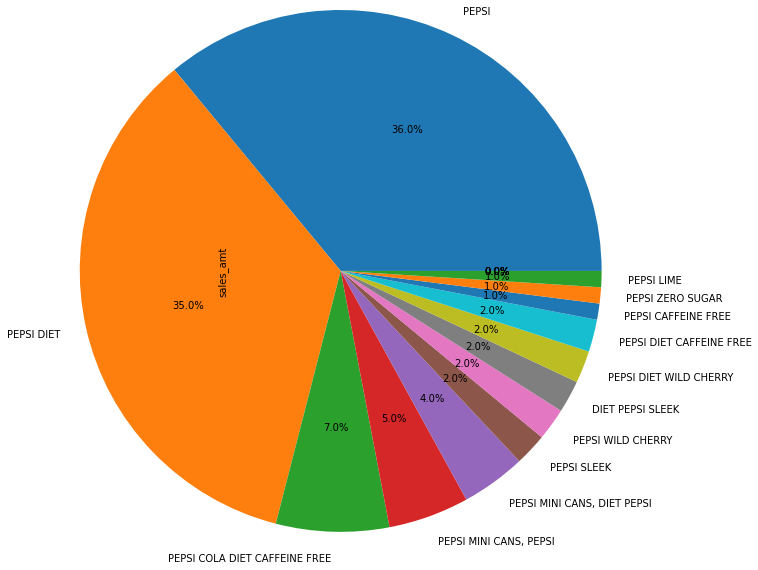

In [54]:
# Market share pie plot
market_share_pepsi.plot.pie(autopct="%.1f%%", radius = 3,normalize=True);

# Sales by Product Category

Pepsi

In [55]:
pepsi4.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False)

prod_desc
PEPSI                            24039.78
PEPSI DIET                       23145.39
PEPSI COLA DIET CAFFEINE FREE     4341.21
PEPSI MINI CANS, PEPSI            3209.47
PEPSI MINI CANS, DIET PEPSI       2424.61
PEPSI SLEEK                       1573.86
PEPSI WILD CHERRY                 1552.84
DIET PEPSI SLEEK                  1277.86
PEPSI DIET WILD CHERRY            1245.85
PEPSI DIET CAFFEINE FREE          1176.64
PEPSI CAFFEINE FREE                792.10
PEPSI ZERO SUGAR                   535.83
PEPSI LIME                         439.37
DIET PEPSI SUGAR FREE              140.07
PEPSI ZERO SUGAR MINIS              42.77
PEPSI 1LT                           11.92
PEPSI GLASS BOTTLE                   3.74
Name: sales_amt, dtype: float64

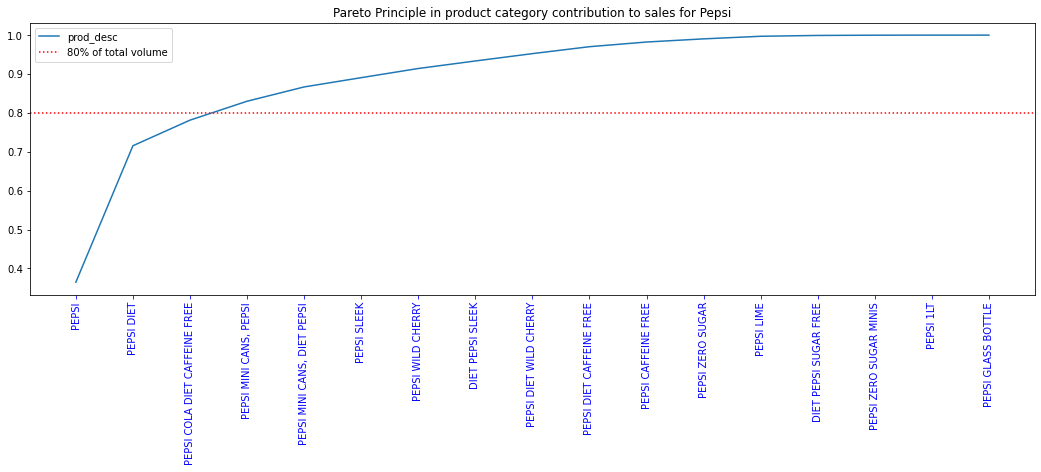

In [56]:
# cumulative sum of sales to find the contribution of categories to sales

pepsi4pareto = pd.DataFrame(pepsi4.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False))
pepsi4pareto['sales_contribution'] = pepsi4pareto.cumsum()\
/ pepsi4pareto.sum()

plt.figure(figsize = (18,5))
plt.plot(pepsi4pareto['sales_contribution'], label = 'prod_desc')
plt.axhline(y = 0.8, color = 'r', linestyle = ':', label = '80% of total volume')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.tick_params(axis = 'x', colors = 'blue')
plt.title('Pareto Principle in product category contribution to sales for Pepsi')
plt.show()

# the top four products make up 80% of the volume sales
# however, it is the top 2 SKUs that make up 70% of sales

Coke

In [57]:
coca4.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False)

prod_desc
COCA-COLA ZERO                    39681.68
COCA-COLA FRIDGEMATE              35579.74
COCA-COLA DIET                    30296.54
COCA-COLA                         20527.26
COCA-COLA CLASSIC                 13313.69
COCA-COLA CLASSIC 500ML BOTTLE     7109.63
COCA-COLA BC RASPBERRY              779.06
COCA-COLA QUEBEC MAPLE              599.88
COCA-COLA ZERO SUGAR                574.87
COCA-COLA ZERO CHERRY               481.50
COCA-COLA ORANGE VANILLA            474.52
COCA-COLA CHERRY VANILLA            461.54
COCA-COLA VANILLA                   370.27
COCA COLA GEORGIA PEACH             337.67
COCA COLA DIET FEISTY CHERRY        278.16
COCA-COLA CHERRY VAN ZERO SUG       237.33
COCA-COLA CHERRY                    233.86
COCA COLA CHERRY                    213.10
COCA-COLA LIME                      126.59
COCA-COLA RASPBERRY                 125.89
COCA-COLA DIET CHERRY                90.15
COCA COLA CHERRY VANILLA ZS          57.48
COCA-COLA DIET BLOOD ORANGE          53.42
C

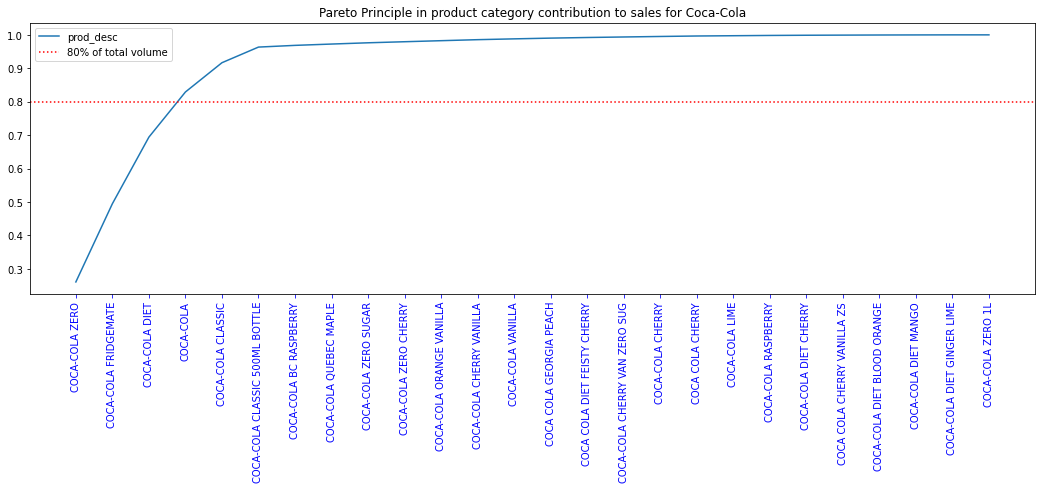

In [58]:
# cumulative sum of sales to find the contribution of categories to sales

coca4pareto = pd.DataFrame(coca4.groupby('prod_desc').sales_amt.sum().sort_values(ascending=False))
coca4pareto['sales_contribution'] = coca4pareto.cumsum()\
/ coca4pareto.sum()

plt.figure(figsize = (18,5))
plt.plot(coca4pareto['sales_contribution'], label = 'prod_desc')
plt.axhline(y = 0.8, color = 'r', linestyle = ':', label = '80% of total volume')
plt.legend()
plt.xticks(rotation = 'vertical')
plt.tick_params(axis = 'x', colors = 'blue')
plt.title('Pareto Principle in product category contribution to sales for Coca-Cola')
plt.show()

# the top four products make up 80% of the volume sales
# a more even contribution within the top 4 unlike that in pepsi, which is dominated by the top 2 (Pepsi, Pepsi Diet)

# Pepsi Users

In [59]:
#show the product price range for pepsi

pep_price_range = pepsi4.groupby(['prod_id'])['unit_price'].agg(['max','min','mean']).reset_index()

price_range1 = pepsi[['prod_id','prod_desc','prod_unit_qty_count','prod_count_uom']].merge(pep_price_range,how = 'inner',on="prod_id")
price_range1

,prod_id,prod_desc,prod_unit_qty_count,prod_count_uom,max,min,mean
0,2.069625e+07,PEPSI GLASS BOTTLE,4.0,ML,3.74,3.740,3.740000
1,2.102030e+07,DIET PEPSI SLEEK,15.0,ML,5.99,4.990,5.974536
2,2.102044e+07,PEPSI SLEEK,15.0,ML,5.99,4.490,5.973264
3,2.109682e+07,PEPSI DIET WILD CHERRY,1.0,ML,2.49,2.000,2.223590
4,2.116408e+07,PEPSI ZERO SUGAR MINIS,6.0,ML,3.29,3.290,3.290000
5,2.118996e+07,PEPSI ZERO SUGAR,6.0,ML,3.29,2.500,2.823176
6,2.003615e+10,PEPSI,1.0,L,1.99,0.940,1.465000
7,2.004020e+10,PEPSI 1LT,1.0,L,1.49,1.490,1.490000
8,2.029693e+10,PEPSI,1.0,L,2.49,0.990,1.896437
9,2.029693e+10,PEPSI DIET,1.0,L,2.49,0.880,1.886784


In [60]:
pepsi4.trans_id.dtype

dtype('int64')

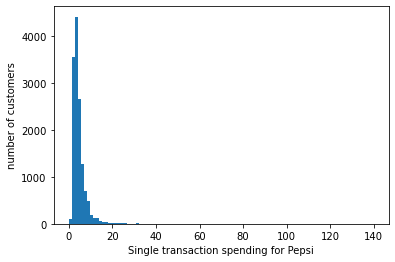

In [61]:
#aggregate by customers
#plot distribution of single transaction spending on pepsi products
import matplotlib.pyplot as plt
x = pepsi4.groupby(['cust_id','trans_id'])['sales_amt'].agg(['sum']).sort_values(ascending = False, by = 'sum')

plt.hist(x, bins = 100)
plt.xlabel("Single transaction spending for Pepsi")
plt.ylabel("number of customers")
plt.show() 

In [62]:
x

,,sum
cust_id,trans_id,
1130458367,180721010140104084,139.70
1135208066,180331010280104859,76.20
1075993305,180612011140309961,59.85
1127767231,190425010350707899,48.00
1133382290,190917010282202007,48.00
...,...,...
1123871795,171221010320904803,0.00
1145066082,170929010142101537,0.00
1133897929,170703010510906725,0.00


In [63]:
# costomers only spend arount $3.99 for soft drinks in medium. 
# The highest spending customers spent $139.7, $76.2, and $59.85 respectively.
# majority spend less than $3.99
print("mean: " +str(np.mean(x['sum']))+ "median: " +str(np.median(x['sum']))+ ", max: "+str(np.max(x['sum'])) + ", min: "+str(np.min(x['sum'])))

mean: 4.7547624540407485median: 3.99, max: 139.7, min: 0.0


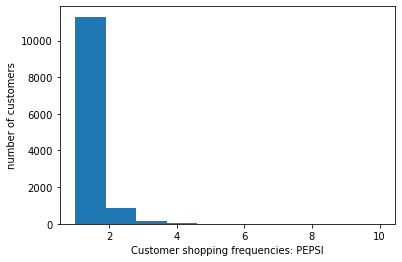

In [64]:
#calculate frequency of customer (total purchase times in 4 years)
y= pepsi4.groupby(['cust_id'])['trans_id'].agg('nunique')
plt.hist(y, bins = 10)
plt.xlabel("Customer shopping frequencies: PEPSI")
plt.ylabel("number of customers")
plt.show() 



In [65]:
y

cust_id
1000031540        1
1000079033        1
1000092785        1
1000299080        1
1000308268        1
                 ..
60003135649150    1
60003135658080    1
60003135887650    1
60003135962800    2
60003135976170    2
Name: trans_id, Length: 12399, dtype: int64

In [66]:
#number of customers who only buy once
y[y==1]
# there are 11298 customers who bought pepsi just once

cust_id
1000031540        1
1000079033        1
1000092785        1
1000299080        1
1000308268        1
                 ..
60003135248470    1
60003135574240    1
60003135649150    1
60003135658080    1
60003135887650    1
Name: trans_id, Length: 11298, dtype: int64

In [67]:
y.sort_values(ascending = False).head(20)

cust_id
1125953626    10
1128011925    10
1051231418     9
1124541591     8
1026590343     8
1137421114     8
1050452726     7
1152402112     7
1008182630     7
1123929562     7
1129347019     6
1125499648     6
1137443518     6
1124240013     6
1142324525     5
1130417354     5
1125997877     5
1124681432     5
1134112143     5
1035473258     5
Name: trans_id, dtype: int64

In [68]:
#the majority of customers only shop once, and the highest frequency is 10 times. 

print("median: " +str(np.median(y))+ ", max: "+str(np.max(y)) + ", min: "+str(np.min(y)))

median: 1.0, max: 10, min: 1


In [69]:
#add column year and date

pepsi4 = pd.concat([pepsi4, 
          (pepsi4.trans_dt.str.split("/").str[:3].apply(pd.Series)
          .rename(columns={ 1:'date', 2:'year'}))], axis = 1)

In [70]:
pepsi4.cust_id.count()

13877

In [71]:
pepsi4.columns

Index([           'trans_id',            'trans_dt',            'store_id',
                   'cust_id',             'prod_id',           'sales_amt',
                 'sales_qty',           'sales_wgt',               'month',
                'unit_price',           'prod_desc',        'prod_section',
             'prod_category',    'prod_subcategory',           'prod_type',
         'prod_mfc_brand_cd', 'prod_unit_qty_count',      'prod_count_uom',
            'prod_uom_value',                     0,                'date',
                      'year'],
      dtype='object')

In [72]:
#customer growth(yoy)
z= pepsi4.groupby(['year'])['cust_id'].agg('nunique')
z

year
2017    1782
2018    4086
2019    3871
2020    3488
Name: cust_id, dtype: int64

# Coca-Cola users

In [73]:
#price range for coca cola
coca_price_range = coca4.groupby(['prod_id'])['unit_price'].agg(['max','min','mean']).reset_index()

price_range = coca[['prod_id','prod_desc','prod_unit_qty_count','prod_count_uom']].merge(coca_price_range,how = 'inner',on="prod_id")
price_range

,prod_id,prod_desc,prod_unit_qty_count,prod_count_uom,max,min,mean
0,2.029905e+07,COCA-COLA,1.0,L,1.99,1.99,1.990000
1,2.065978e+07,COCA-COLA ZERO 1L,1.0,L,1.99,1.29,1.640000
2,2.078341e+07,COCA-COLA DIET,1.0,L,2.19,1.99,2.104286
3,2.082729e+07,COCA-COLA CLASSIC 500ML BOTTLE,1.0,ML,2.49,0.99,2.240705
4,2.089531e+07,COCA COLA CHERRY,1.0,ML,2.49,2.00,2.281333
5,2.094114e+07,COCA-COLA CHERRY,24.0,ML,3.99,3.99,3.990000
6,2.096825e+07,COCA-COLA VANILLA,1.0,ML,2.49,2.00,2.194593
7,2.097098e+07,COCA-COLA CLASSIC,1.0,L,1.79,1.49,1.639016
8,2.102156e+07,COCA-COLA ZERO CHERRY,12.0,ML,5.79,3.79,4.114531
9,2.102200e+07,COCA-COLA ZERO CHERRY,1.0,ML,2.49,2.00,2.245854


In [74]:
#add column year and date

coca4 = pd.concat([coca4, 
          (coca4.trans_dt.str.split("/").str[:3].apply(pd.Series)
          .rename(columns={1:'date', 2:'year'}))], axis = 1)

In [75]:
coca4.cust_id.count()

33681

In [76]:
coca4.columns

Index([           'trans_id',            'trans_dt',            'store_id',
                   'cust_id',             'prod_id',           'sales_amt',
                 'sales_qty',           'sales_wgt',               'month',
                'unit_price',           'prod_desc',        'prod_section',
             'prod_category',    'prod_subcategory',           'prod_type',
         'prod_mfc_brand_cd', 'prod_unit_qty_count',      'prod_count_uom',
            'prod_uom_value',                     0,                'date',
                      'year'],
      dtype='object')

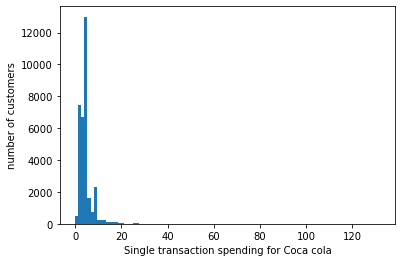

In [77]:
#aggregate by customers
#plot distribution of single transaction spending on coke products

x1 = coca4.groupby(['cust_id','trans_id'])['sales_amt'].agg(['sum']).sort_values(ascending = False, by = 'sum')

plt.hist(x1, bins = 100)
plt.xlabel("Single transaction spending for Coca cola")
plt.ylabel("number of customers")
plt.show() 

In [78]:
x1.head()

,,sum
cust_id,trans_id,
60002580995470,180704010100604443,131.76
24600409011750,191005010502300355,103.52
1127454309,191007010210300482,90.58
1068189984,180202010280307528,79.25
33224444015,180626010820301423,69.85


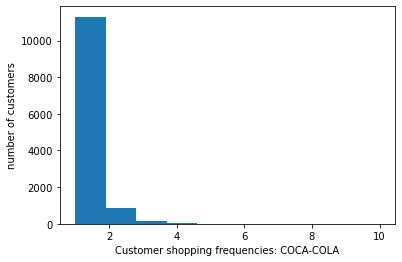

In [79]:
#calculate frequency of customer (total purchase times in 4 years)
y2= coca4.groupby(['cust_id'])['trans_id'].agg('nunique')
plt.hist(y, bins = 10)
plt.xlabel("Customer shopping frequencies: COCA-COLA")
plt.ylabel("number of customers")
plt.show() 

In [80]:
#number of customers who only buy once
y2[y2==1]
# there are 28051 customers who bought pepsi just once

cust_id
1000058209        1
1000098267        1
1000135261        1
1000141837        1
1000172090        1
                 ..
60003135179840    1
60003135205860    1
60003135892880    1
60003135916000    1
60003136003760    1
Name: trans_id, Length: 28051, dtype: int64

In [81]:
#the majority of customers only shop once, and the highest frequency is 9 times. 

print("median: " +str(np.median(y2))+ ", max: "+str(np.max(y2)) + ", min: "+str(np.min(y2)))

median: 1.0, max: 9, min: 1


In [82]:
# costomers  spend arount $3.99 for soft drinks in medium. 
# The highest spending customers spent $131.76, $103.52, and $90.58 respectively.
# majority spend less than $4
print("mean: " +str(np.mean(x1['sum']))+ "median: " +str(np.median(x1['sum']))+ ", max: "+str(np.max(x1['sum'])) + ", min: "+str(np.min(x1['sum'])))

mean: 4.517723775290377median: 3.99, max: 131.76, min: 0.0


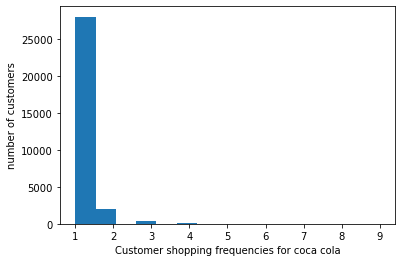

In [83]:
#calculate frequency of customer (total purchase times in 4 years)
y1= coca4.groupby(['cust_id'])['trans_id'].agg('nunique')
plt.hist(y1, bins = 15)
plt.xlabel("Customer shopping frequencies for coca cola")
plt.ylabel("number of customers")
plt.show() 

In [84]:
#customer growth(yoy). How many unique customers in a year
z1= coca4.groupby(['year'])['cust_id'].agg('nunique')
z1


year
2017    4535
2018    9585
2019    9098
2020    9100
Name: cust_id, dtype: int64

In [85]:
coca4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33681 entries, 0 to 33680
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trans_id             33681 non-null  int64  
 1   trans_dt             33681 non-null  object 
 2   store_id             33681 non-null  int64  
 3   cust_id              33681 non-null  int64  
 4   prod_id              33681 non-null  int64  
 5   sales_amt            33681 non-null  float64
 6   sales_qty            33681 non-null  int64  
 7   sales_wgt            33681 non-null  float64
 8   month                33681 non-null  int64  
 9   unit_price           33623 non-null  float64
 10  prod_desc            33681 non-null  object 
 11  prod_section         33681 non-null  object 
 12  prod_category        33681 non-null  object 
 13  prod_subcategory     33681 non-null  object 
 14  prod_type            33681 non-null  object 
 15  prod_mfc_brand_cd    33681 non-null 

# Recommender Choice

Consider the product analysis and the customer group analysis, we decided that we promote Coca cola because it shares a much larger market

In [86]:
# Next, consider price sensitivity
# products to promote: take up to 75% market, has discount history before.
# 'COCA-COLA ZERO','COCA-COLA FRIDGEMATE','COCA-COLA DIET','COCA-COLA'
price_range.loc[price_range.prod_desc.isin\
                 (['COCA-COLA ZERO','COCA-COLA FRIDGEMATE','COCA-COLA DIET','COCA-COLA'])]

,prod_id,prod_desc,prod_unit_qty_count,prod_count_uom,max,min,mean
0,2.029905e+07,COCA-COLA,1.0,L,1.99,1.99,1.990000
2,2.078341e+07,COCA-COLA DIET,1.0,L,2.19,1.99,2.104286
13,2.105977e+07,COCA-COLA ZERO,10.0,ML,4.49,2.99,4.218765
14,2.105979e+07,COCA-COLA DIET,10.0,ML,4.49,3.49,4.290095
33,2.030820e+10,COCA-COLA,24.0,ML,10.99,0.69,7.210508
34,2.030820e+10,COCA-COLA ZERO,24.0,ML,10.99,6.35,7.775517
35,2.031374e+10,COCA-COLA ZERO,6.0,ML,4.99,1.97,4.532268
36,2.031374e+10,COCA-COLA,6.0,ML,4.99,1.49,4.489911
37,2.031603e+10,COCA-COLA,1.0,L,2.49,0.99,1.896668
38,2.031603e+10,COCA-COLA ZERO,1.0,L,2.49,0.99,1.908341


In [87]:
#merge back to original dataset

target = coca4.merge\
(price_range[['prod_id','max']],how = 'inner',on = 'prod_id')
target.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,0,date,year,max
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,Carbonated Soft Drin,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49


In [88]:
target['frequency'] = target.groupby\
(['cust_id'])['trans_id'].transform('nunique')
target

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,0,date,year,max,frequency
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49,1
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49,1
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49,1
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49,1
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,Bottles,COCA,1.0,L,2.0,6,24,2017,2.49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33676,200817010900308427,8/17/2020,1090,1128776079,21295933,8.00,4,0.0,8,2.00,...,Cans,COCA,1.0,ML,500.0,8,17,2020,2.29,1
33677,200821010070600904,8/21/2020,1007,1123909498,21295933,2.29,1,0.0,8,2.29,...,Cans,COCA,1.0,ML,500.0,8,21,2020,2.29,1
33678,200829010215008493,8/29/2020,1021,1116966188,21295933,2.00,1,0.0,8,2.00,...,Cans,COCA,1.0,ML,500.0,8,29,2020,2.29,1
33679,200830011420203449,8/30/2020,1142,1133982740,21295933,2.29,1,0.0,8,2.29,...,Cans,COCA,1.0,ML,500.0,8,30,2020,2.29,1


In [89]:
target['is_discount'] = (target.unit_price != target['max'])

target

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,0,date,year,max,frequency,is_discount
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,COCA,1.0,L,2.0,6,24,2017,2.49,1,True
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,COCA,1.0,L,2.0,6,24,2017,2.49,1,True
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,COCA,1.0,L,2.0,6,24,2017,2.49,1,True
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,COCA,1.0,L,2.0,6,24,2017,2.49,1,True
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,COCA,1.0,L,2.0,6,24,2017,2.49,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33676,200817010900308427,8/17/2020,1090,1128776079,21295933,8.00,4,0.0,8,2.00,...,COCA,1.0,ML,500.0,8,17,2020,2.29,1,True
33677,200821010070600904,8/21/2020,1007,1123909498,21295933,2.29,1,0.0,8,2.29,...,COCA,1.0,ML,500.0,8,21,2020,2.29,1,False
33678,200829010215008493,8/29/2020,1021,1116966188,21295933,2.00,1,0.0,8,2.00,...,COCA,1.0,ML,500.0,8,29,2020,2.29,1,True
33679,200830011420203449,8/30/2020,1142,1133982740,21295933,2.29,1,0.0,8,2.29,...,COCA,1.0,ML,500.0,8,30,2020,2.29,1,False


In [90]:
# Ideal customers:
#  To find customers who are likely to accept promotion offers, 
#   we looked for customers who had relatively high promotion use
#   and their shopping is tied to high purchase value (product quantity>= 3)

# discount usage
target['discount_times'] = target.groupby\
(['cust_id'])['is_discount'].transform('sum')

# purchase times
target['total_purchase_times'] = target.groupby\
(['cust_id'])['sales_amt'].transform('count')

target

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_count_uom,prod_uom_value,0,date,year,max,frequency,is_discount,discount_times,total_purchase_times
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,L,2.0,6,24,2017,2.49,1,True,1,1
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,L,2.0,6,24,2017,2.49,1,True,1,1
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,L,2.0,6,24,2017,2.49,1,True,1,1
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,L,2.0,6,24,2017,2.49,1,True,1,1
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,L,2.0,6,24,2017,2.49,1,True,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33676,200817010900308427,8/17/2020,1090,1128776079,21295933,8.00,4,0.0,8,2.00,...,ML,500.0,8,17,2020,2.29,1,True,1,1
33677,200821010070600904,8/21/2020,1007,1123909498,21295933,2.29,1,0.0,8,2.29,...,ML,500.0,8,21,2020,2.29,1,False,0,1
33678,200829010215008493,8/29/2020,1021,1116966188,21295933,2.00,1,0.0,8,2.00,...,ML,500.0,8,29,2020,2.29,1,True,1,1
33679,200830011420203449,8/30/2020,1142,1133982740,21295933,2.29,1,0.0,8,2.29,...,ML,500.0,8,30,2020,2.29,1,False,0,1


In [91]:
#sales of coca cola 80%% target group in discount

(target['sales_amt']*target['is_discount']).sum()

137732.55

In [92]:
#total sales of coca cola 80% target group
 
target['sales_amt'].sum()

152071.1

In [93]:
#percentage of discounted sales
round((target['sales_amt']*target['is_discount']).sum()/target['sales_amt'].sum(),4)

0.9057

In [94]:
#similarly, calculate the percentage of pepsi main groups that make 80% of sales

top80pepsi = ['PEPSI','PEPSI DIET','PEPSI COLA DIET CAFFEINE FREE','PEPSI MINI CANS, PEPSI']
target_pepsi = pepsi4.loc[pepsi4['prod_desc'].isin (top80pepsi)] 
price_range1.head()

,prod_id,prod_desc,prod_unit_qty_count,prod_count_uom,max,min,mean
0,20696253.0,PEPSI GLASS BOTTLE,4.0,ML,3.74,3.74,3.740000
1,21020295.0,DIET PEPSI SLEEK,15.0,ML,5.99,4.99,5.974536
2,21020441.0,PEPSI SLEEK,15.0,ML,5.99,4.49,5.973264
3,21096815.0,PEPSI DIET WILD CHERRY,1.0,ML,2.49,2.00,2.223590
4,21164079.0,PEPSI ZERO SUGAR MINIS,6.0,ML,3.29,3.29,3.290000


In [95]:
target_pepsi1 = target_pepsi.merge(price_range1[['prod_id','max']],how = 'inner',on = 'prod_id')

In [96]:
target_pepsi1['is_discount'] = (target_pepsi1.unit_price != target_pepsi1['max'])

In [97]:
(target_pepsi['sales_amt']*target_pepsi1['is_discount']).sum()

42203.0900000015

In [98]:
target_pepsi1['sales_amt'].sum()

54735.85

In [99]:
round((target_pepsi['sales_amt']*target_pepsi1['is_discount']).sum()/target_pepsi1['sales_amt'].sum(),4)

0.771

In [100]:
target['percent_discount_buy'] = target['discount_times']/target['total_purchase_times']

In [101]:
# find the price sensitive customers
customer = target.loc[(target['total_purchase_times']>1) & (target['percent_discount_buy']>0.5)]
customer.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,prod_uom_value,0,date,year,max,frequency,is_discount,discount_times,total_purchase_times,percent_discount_buy
41,170702010902404314,7/2/2017,1090,60002656553300,20316026002,0.99,1,0.0,7,0.99,...,2.0,7,2,2017,2.49,2,True,2,2,1.0
45,170705011700609830,7/5/2017,1170,1127073696,20316026002,1.98,2,0.0,7,0.99,...,2.0,7,5,2017,2.49,2,True,2,2,1.0
56,170707010640509093,7/7/2017,1064,60002080439720,20316026002,1.99,1,0.0,7,1.99,...,2.0,7,7,2017,2.49,2,True,2,2,1.0
62,170710010500500927,7/10/2017,1050,1129421349,20316026002,1.99,1,0.0,7,1.99,...,2.0,7,10,2017,2.49,3,True,3,3,1.0
79,170717010992106658,7/17/2017,1099,60002780662060,20316026002,3.98,2,0.0,7,1.99,...,2.0,7,17,2017,2.49,4,True,4,4,1.0


In [102]:
#for this customers, choose those whose sales quantity >= 3

ideal_cust = customer.loc[customer['sales_qty'] >= 3 ]

In [103]:
cust_list = pd. unique(ideal_cust['cust_id'])

In [104]:
#size of base customer
len(cust_list)

245

In [105]:
# Average number of visits of the ideal customer in each month
customer[customer['cust_id'].isin (cust_list)]['percent_discount_buy'].sum()/\
customer[customer['cust_id'].isin (cust_list)].shape[0]

0.9787928221859706

In [106]:
customer[customer['cust_id'].isin (cust_list)]['is_discount'].sum()/42/len(cust_list)

0.05830903790087464

In [107]:
# customer size * visit within 2 weeks * discount purchase propensity * average discounted price = Sales
CampaignSales = 245*.978*4.222980
CampaignSales

1011.8682377999999

In [108]:
target.dtypes

trans_id                  int64
trans_dt                 object
store_id                  int64
cust_id                   int64
prod_id                   int64
sales_amt               float64
sales_qty                 int64
sales_wgt               float64
month                     int64
unit_price              float64
prod_desc                object
prod_section             object
prod_category            object
prod_subcategory         object
prod_type                object
prod_mfc_brand_cd        object
prod_unit_qty_count     float64
prod_count_uom           object
prod_uom_value          float64
0                        object
date                     object
year                     object
max                     float64
frequency                 int64
is_discount                bool
discount_times            int64
total_purchase_times      int64
percent_discount_buy    float64
dtype: object

In [109]:
# target.groupby('prod_id').agg(float('discount_times')*float('sales_amt')).head()
target['discounted_sales_total'] = target.discount_times* target.sales_amt
target.head()

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,...,0,date,year,max,frequency,is_discount,discount_times,total_purchase_times,percent_discount_buy,discounted_sales_total
0,170624011790603436,6/24/2017,1179,1123993771,20316026002,1.99,1,0.0,6,1.99,...,6,24,2017,2.49,1,True,1,1,1.0,1.99
1,170624010282500484,6/24/2017,1028,1036901442,20316026002,1.99,1,0.0,6,1.99,...,6,24,2017,2.49,1,True,1,1,1.0,1.99
2,170624012120607760,6/24/2017,1212,1013070896,20316026002,1.99,1,0.0,6,1.99,...,6,24,2017,2.49,1,True,1,1,1.0,1.99
3,170624010070300589,6/24/2017,1007,1134483254,20316026002,1.99,1,0.0,6,1.99,...,6,24,2017,2.49,1,True,1,1,1.0,1.99
4,170624010790509449,6/24/2017,1079,60002766502940,20316026002,1.99,1,0.0,6,1.99,...,6,24,2017,2.49,1,True,1,1,1.0,1.99


In [110]:
PIDtargetpareto = pd.DataFrame(target.groupby('prod_id').discounted_sales_total.sum().sort_values(ascending=False))
PIDtargetpareto['discounted_sales_contribution'] = PIDtargetpareto.cumsum()/ PIDtargetpareto.sum()
PIDtargetpareto.head(10)

,discounted_sales_total,discounted_sales_contribution
prod_id,,
20318694002,43441.23,0.248069
20318694001,32915.90,0.436033
20318694003,31938.68,0.618417
20354288002,10742.69,0.679762
20308197001,10023.95,0.737003
20827293,9116.92,0.789065
20316026002,8684.27,0.838656
20316026005,6942.92,0.878303
20354288003,5518.48,0.909816


In [111]:
topdiscountedPIDs = PIDtargetpareto[PIDtargetpareto['discounted_sales_contribution']<= .8].index

In [112]:
products[products['prod_id'].isin([topdiscountedPIDs[0]])][['prod_id','prod_desc']]
# If we have to promote one CSD, 
# then we should promote Coca-cola Fridgemate to the 245 customers identified above

,prod_id,prod_desc
139044,2.031869e+10,COCA-COLA FRIDGEMATE


In [113]:
recoPID = []
for i in range(0,len(topdiscountedPIDs),1):
    x = products[products['prod_id'].isin([topdiscountedPIDs[i]])]['prod_desc']
    recoPID.append(x)
    
print(recoPID)

# If ACSE wants more options other than COCA-COLA FRIDGEMATE, 
# then the options include (from best to worst)
# Coca-Cola Zero, Coca-Cola Diet, COCA-COLA CLASSIC, COCA COLA, COCA-COLA CLASSIC 500ML BOTTLE

[139044    COCA-COLA FRIDGEMATE
Name: prod_desc, dtype: object, 139043    Coca-Cola Zero
Name: prod_desc, dtype: object, 139045    Coca-Cola Diet
Name: prod_desc, dtype: object, 141688    COCA-COLA CLASSIC
Name: prod_desc, dtype: object, 136684    COCA COLA
Name: prod_desc, dtype: object, 35344    COCA-COLA CLASSIC 500ML BOTTLE
Name: prod_desc, dtype: object]


## Experimental

In [114]:
# transactions data has been filtered to rid off the customers who bought any of the ACSE branded CSDs
transactions.head(5)

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price
0,170625010050404567,6/25/2017,1005,1008061498,21031312,2.49,1,0.0,6,2.49
1,170624010220809847,6/24/2017,1022,1133995672,20189092,0.05,1,0.0,6,0.05
2,170624010100701456,6/24/2017,1010,60003034881280,20708931,11.99,1,0.0,6,11.99
3,170624010210702469,6/24/2017,1021,1008762288,20169567,9.00,1,0.2,6,9.00
4,170624010660808197,6/24/2017,1066,1148460508,20314333,34.38,3,0.0,6,11.46


In [115]:
# Make a pareto distribution of the product ids that are being sold.
# del Prdpareto

Prdpareto = pd.DataFrame(transactions.groupby('prod_id').sales_qty.sum().sort_values(ascending=False))
Prdpareto['pid_contribution_qty'] = Prdpareto.cumsum()\
/ Prdpareto.sum()
Prdpareto = Prdpareto[Prdpareto.pid_contribution_qty <= 0.8]
Prdpareto

,sales_qty,pid_contribution_qty
prod_id,,
20189092,852905,0.058003
20175355001,190731,0.070974
21097012001,96358,0.077527
20028593001,82680,0.083150
20040489001,75596,0.088291
...,...,...
20010752,304,0.799914
21081926,304,0.799934
20858479,304,0.799955


In [116]:
# Make a list of the top sold products in terms of qty
# del paretopid
paretopid = Prdpareto.index.unique()
len(paretopid)

8638

In [117]:
# include the prod_id of top selling coca cola and pepsi products
paretopid = (np.concatenate((paretopid, coca4['prod_id'].unique(), pepsi4['prod_id'].unique())))
len(paretopid)

8711

In [118]:
# our ideal customer list is in the cust_list array.
# we want to find association of the 8638 product items for this 245 customers.

PIDCUSTdf = merged[ merged['cust_id'].isin(cust_list) ]
PIDCUSTdf = PIDCUSTdf[ PIDCUSTdf['prod_id'].isin (paretopid) ]
PIDCUSTdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6860 entries, 5219 to 11690213
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   trans_id             6860 non-null   int64  
 1   trans_dt             6860 non-null   object 
 2   store_id             6860 non-null   int64  
 3   cust_id              6860 non-null   int64  
 4   prod_id              6860 non-null   int64  
 5   sales_amt            6860 non-null   float64
 6   sales_qty            6860 non-null   int64  
 7   sales_wgt            6860 non-null   float64
 8   month                6860 non-null   int64  
 9   unit_price           6853 non-null   float64
 10  prod_desc            6860 non-null   object 
 11  prod_section         6860 non-null   object 
 12  prod_category        6860 non-null   object 
 13  prod_subcategory     6860 non-null   object 
 14  prod_type            6860 non-null   object 
 15  prod_mfc_brand_cd    6860 non-n

In [119]:
# PIDCUSTdf2=PIDCUSTdf.drop_duplicates(subset=['cust_id','prod_id'])
# PIDCUSTdf2.info()

In [120]:
# df_matrix = pd.pivot_table(PIDCUSTdf2, values='sales_qty',aggfunc=lambda x:(x>0).sum(), index='prod_id', columns='cust_id')
# df_matrix

In [121]:
# df_matrix_norm = (df_matrix-df_matrix.min())/(df_matrix.max()-df_matrix.min())
# df_matrix_norm

In [122]:
# # create a table for input to the modeling  
# d = df_matrix_norm.reset_index() 
# d.index.names = ['scaled_purchase_freq'] 
# data_norm = pd.melt(d, id_vars=['prod_id'], value_name='scaled_purchase_freq').dropna()
# print(data_norm.shape)
# data_norm.head()

In [123]:
PIDCUSTdf

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value
5219,170707010200409119,7/7/2017,1020,1133377837,20189092,0.20,4,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0
5372,170708010072106002,7/8/2017,1007,1124666995,20189092,0.05,1,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0
6646,170710011142509325,7/10/2017,1114,1125051453,20189092,0.05,1,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0
7040,170713010105709774,7/13/2017,1010,1125654055,20189092,0.05,1,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0
8463,170715010510505500,7/15/2017,1051,1129257061,20189092,0.10,2,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11678911,200910010040502920,9/10/2020,1004,1123913855,21289745,10.00,2,0.0,9,5.00,ACSE FARMERS MARBLE,Dairy,Cheese/Butter/Margarine,Cheese,Block,ACSE,1.0,G,400.0
11680630,200606011140108558,6/6/2020,1114,1125051453,21297816,4.00,2,0.0,6,2.00,ACSE BAGEL PLAIN 6PK,Bakery Commercial,Commercial,Alternatives-Commerc,Bagels,ACSE,1.0,G,510.0
11683230,200510011320108301,5/10/2020,1132,1127413910,21305805,5.00,1,0.0,5,5.00,GIRL GUIDES CLASSIC COOKIE,Grocery,Snacks,Cookies,Family,GRLG,1.0,G,280.0
11688523,200609010792504092,6/9/2020,1079,1143973338,21285976001,3.99,1,0.0,6,3.99,ACSE TOMATO MIXIANY 255G,Produce,Vegetables,Tomatoes,Cherry,ACSE,1.0,G,255.0


In [124]:
PIDCUSTdf['PID']= PIDCUSTdf['prod_id'].astype(str) + "_" + PIDCUSTdf['prod_desc']

In [125]:
PIDCUSTdf

,trans_id,trans_dt,store_id,cust_id,prod_id,sales_amt,sales_qty,sales_wgt,month,unit_price,prod_desc,prod_section,prod_category,prod_subcategory,prod_type,prod_mfc_brand_cd,prod_unit_qty_count,prod_count_uom,prod_uom_value,PID
5219,170707010200409119,7/7/2017,1020,1133377837,20189092,0.20,4,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0,20189092_ACSE PLASTIC BAGS
5372,170708010072106002,7/8/2017,1007,1124666995,20189092,0.05,1,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0,20189092_ACSE PLASTIC BAGS
6646,170710011142509325,7/10/2017,1114,1125051453,20189092,0.05,1,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0,20189092_ACSE PLASTIC BAGS
7040,170713010105709774,7/13/2017,1010,1125654055,20189092,0.05,1,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0,20189092_ACSE PLASTIC BAGS
8463,170715010510505500,7/15/2017,1051,1129257061,20189092,0.10,2,0.0,7,0.05,ACSE PLASTIC BAGS,Home,Household,Front End Bags,Front End Bags,ACSE,1.0,EA,1.0,20189092_ACSE PLASTIC BAGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11678911,200910010040502920,9/10/2020,1004,1123913855,21289745,10.00,2,0.0,9,5.00,ACSE FARMERS MARBLE,Dairy,Cheese/Butter/Margarine,Cheese,Block,ACSE,1.0,G,400.0,21289745_ACSE FARMERS MARBLE
11680630,200606011140108558,6/6/2020,1114,1125051453,21297816,4.00,2,0.0,6,2.00,ACSE BAGEL PLAIN 6PK,Bakery Commercial,Commercial,Alternatives-Commerc,Bagels,ACSE,1.0,G,510.0,21297816_ACSE BAGEL PLAIN 6PK
11683230,200510011320108301,5/10/2020,1132,1127413910,21305805,5.00,1,0.0,5,5.00,GIRL GUIDES CLASSIC COOKIE,Grocery,Snacks,Cookies,Family,GRLG,1.0,G,280.0,21305805_GIRL GUIDES CLASSIC COOKIE
11688523,200609010792504092,6/9/2020,1079,1143973338,21285976001,3.99,1,0.0,6,3.99,ACSE TOMATO MIXIANY 255G,Produce,Vegetables,Tomatoes,Cherry,ACSE,1.0,G,255.0,21285976001_ACSE TOMATO MIXIANY 255G


2. Calculating sparsity

In order for collaborative filtering to work, we need to make sure the sparsity level does not go over 99.5%

In [126]:
# The score will be based on how many times a customer has purchased an item converted to 1-5 scale

recData = PIDCUSTdf.groupby(['cust_id','PID'], as_index = False).agg({'sales_qty': 'nunique'})

recData.rename(columns = {'sales_qty':'score'}, inplace = True)


recData

,cust_id,PID,score
0,1008305136,20117370001_ACSE CARROTS MINI 340G,1
1,1008305136,20170862_FRENCHS MUSTARD SQZ,1
2,1008305136,20189092_ACSE PLASTIC BAGS,1
3,1008305136,20318694002_COCA-COLA FRIDGEMATE,2
4,1008305136,20612259_ACSE Decadent Chocolate Chunk Cookies,1
...,...,...,...
5914,60003065142990,20306510_ACSE POTATO CHIPS REGULAR,1
5915,60003065142990,20310858_MINUTE RICE,1
5916,60003065142990,20318694001_Coca-Cola Zero,2
5917,60003065142990,20500252_HL MARKET CUTS - SALMON LOINS,1


In [127]:
pivotData = pd.pivot_table(recData, values = 'score', index = 'cust_id', 
                            columns = 'PID', aggfunc = np.sum)
masked = np.ma.masked_invalid(pivotData)
mc = masked.compressed()
print(1 - mc.shape[0]/np.prod(pivotData.shape))

# The maximum recommended sparsity is 99.5%

0.9920555134253636


# Collaborative filtering

In [128]:
# Create a sparse matrix

recData['cust_id'] = recData['cust_id'].astype("category")
recData['PID'] = recData['PID'].astype("category")
recData['user'] = recData['cust_id'].cat.codes
recData['item'] = recData['PID'].cat.codes

In [129]:
# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
sparseItemUser = scipy.sparse.csr_matrix((recData['score'].astype(float), (recData['item'], recData['user'])))
sparseUserItem = scipy.sparse.csr_matrix((recData['score'].astype(float), (recData['user'], recData['item'])))

In [130]:
# Initialize the als model and fit it using the sparse item-user matrix
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

In [131]:
# Calculate the confidence by multiplying it by alpha value, based on the methodologies of 

alphaVal = 15
dataConf = (sparseItemUser * alphaVal).astype('double')

In [132]:
#Fit the model
model.fit(dataConf)

  0%|          | 0/50 [00:00<?, ?it/s]

In [133]:
# Helper functions

def getUserItems(user):
    """
    returns a list of item descriptions a user bought
    
    user: user categorical code 
    """
    return recData[recData['user'] == user]['PID'].astype('str').unique()

def getItemDescription(items):
    """
    returns a list of descriptions given a list of items
    
    items: list of item categorical code
    """
    descriptions = []
    for item in items:
        descriptions.extend(recData[recData['item'] == item ]['PID'].astype('str').unique())
    return descriptions

def getUserRecommendations(user):
    """
    returns a dictionary of item categorical code and score
    
    user: user categorical code
    """
    itemRecs = {}
    recommended = model.recommend(user, sparseUserItem)
    for item in recommended:
        itemRecs[item[0]] = item[1]
    return itemRecs

def getSimilarItems(item):
    """
    returns a dictionary of item categorical code and score
    
    item: item categorical code
    """
    similar = model.similar_items(item, 11)
    similar.pop(0)
    similarItems = {}
    for item in similar:
        similarItems[item[0]] = item[1]
    return similarItems


In [134]:
# Check the recommender system
print("User purchased:", getUserItems(6))

print("Recomendations:", getItemDescription(getUserRecommendations(6).keys()))

# User 6 bought mainly snacks and drinks, with Coca-Cola Zero 
# The recommendations include Coke Fridgemate with Coca-Cola Zero

User purchased: ['20007535001_PEPPERS RED SWEET' '20016394_BALDERSON 2 YR CHEDDAR CHEESE'
 '20039581001_KRAFT PNUT BTR SMOOTH' '20088387001_PEPPERS HOT JALAPENO'
 '20091825001_CILANTRO' '20107500001_ONION GREEN'
 '20159690001_CHERRIES RED' '20304672001_ACSE MARSHMALLOWS LARGE REG'
 '20318694001_Coca-Cola Zero' '20319458002_NORD COTT CHEESE CRM'
 '20322348006_CAMP BROTH CHICKEN NSA' '20548797_JET-DRY ORIGINAL'
 '20619888001_ACSE BM CHICKEN CHUNKS'
 "20655627003_LAY'S XL POTATO CHIPS WVY REG"
 '20659606001_KRAFT CHEEZ WHIZ' '20679626_OCEAN SPRAY CKTL DT CRAN CHER'
 '20711049_ROYALE TIGER TOWELS 6 RL 70CT' '20943750_DORITOS NACHO CHEESE'
 "20945417_MISS VICKIE'S SOUR CRM ONI GFPF"
 '21005376_ACSE MUSHROOM ENOKI 150G'
 '21005382_ACSE MUSHROOM SLCD CREMINI 227G'
 '21203746_ACSE BABY SPINACH 142G']
Recomendations: ['20189092_ACSE PLASTIC BAGS', '20318694002_COCA-COLA FRIDGEMATE', '20426596001_ZUCCHINI GREEN', '20143381001_TOMATO ROMA', '20289672_ACSE PORK BACK RIBS 2PK COV', '20770659_SHOPSY

In [135]:
print("User purchased:", getUserItems(244))

print("Recomendations:", getItemDescription(getUserRecommendations(244).keys()))

# User 244 bought mainly lunch/dinner items, with Coca-Cola Zero 
# The recommendations include Coca-Cola Zero

User purchased: ['20060696_NESTLE PURE LIFE' '20111346_ACSE FF AC CHKN BRST CUTLET TP'
 '20306510_ACSE POTATO CHIPS REGULAR' '20310858_MINUTE RICE'
 '20318694001_Coca-Cola Zero' '20500252_HL MARKET CUTS - SALMON LOINS'
 '20974528_ACSE EYE RND STEAK BF']
Recomendations: ['20189092_ACSE PLASTIC BAGS', '20175355001_BANANA', '20354288001_COCA- COLA ZERO', '20168304001_ONION YELLOW', '20338720_ACSE MUFFINS CHOCOLATE CHIP', '20592786_ACSE DONUTS BULK MIX&MTCH - NON FRY', '20812144001_ACSE GRADE A EGGS LARGE WHITE, EA', '20043212001_ONION SPANISH', '21179041_ACSE LEAN GROUND BEEF FW', '21003833_PRINGLES CA ORIG CRISPS']


In [136]:
recData

,cust_id,PID,score,user,item
0,1008305136,20117370001_ACSE CARROTS MINI 340G,1,0,390
1,1008305136,20170862_FRENCHS MUSTARD SQZ,1,0,581
2,1008305136,20189092_ACSE PLASTIC BAGS,1,0,666
3,1008305136,20318694002_COCA-COLA FRIDGEMATE,2,0,1125
4,1008305136,20612259_ACSE Decadent Chocolate Chunk Cookies,1,0,1594
...,...,...,...,...,...
5914,60003065142990,20306510_ACSE POTATO CHIPS REGULAR,1,244,905
5915,60003065142990,20310858_MINUTE RICE,1,244,964
5916,60003065142990,20318694001_Coca-Cola Zero,2,244,1124
5917,60003065142990,20500252_HL MARKET CUTS - SALMON LOINS,1,244,1425


In [137]:
# Check similar item recommendation
print("Original item:", getItemDescription([800]))

print("Recomendations:", getItemDescription(getSimilarItems(6).keys()))

Original item: ['20299821_SCH JUMBO SUMMER SAUSAGE SV']
Recomendations: ['21021466_AGRO ST-AGUR FRENCH CHEESE', '21024379_ACSE JF 100CT EXFO COTTON PAD', '20001552_ACSE 1PC CHICKEN WINGS', '20318955001_MOTTS CLAMATO THE WORKS', '20629532003_ORVILLE POPCORN PUB EXTRA BUTTERY', '21074552_NESCAFE GLD DARK RST SGNT JR', '20074920_GLOBE AND MAIL SATURDAY', '20169567_NORWEGIAN JARLSBURG CHEESE', '21067660_MA ITALIAN PORK MEATBALLS', '20733958_ACSE SANDWICH BACON RNDS NATURALLY SMKD']
